In [87]:
import dgl.nn as dglnn
import math
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from collections import defaultdict
import gc
import torch.nn.init as init
from dgl.nn.functional import edge_softmax

In [88]:
import torch
torch.__version__

'2.4.0+cu124'

In [90]:
def load_data(fp):
    return pd.read_csv(fp)

def subsample_data(df, label, subsample=True, frac=0.1, random_state=13):
    if subsample:
        return df.groupby(by=label).sample(frac=frac, random_state=random_state)
    return df

def drop_columns(df, cols):
    return df.drop(columns=cols, axis=1, errors="ignore")

def drop_rows_by_label(df, label_col, label):
    return df[df[label_col] != label]

def convert_addrs(df, src_ip_col, dst_ip_col, src_port_col, dst_port_col):
    import socket, struct, random

    df[dst_ip_col] = df[dst_ip_col].apply(
        lambda x: socket.inet_ntoa(
            struct.pack(">I", random.randint(0xAC100001, 0xAC1F0001))
        )
    )
    df[src_ip_col] = df[src_ip_col].astype(str)
    df[src_port_col] = df[src_port_col].astype(str)
    df[dst_ip_col] = df[dst_ip_col].astype(str)
    df[dst_port_col] = df[dst_port_col].astype(str)

    df[src_ip_col] = df[src_ip_col] + ":" + df[src_port_col]
    df[dst_ip_col] = df[dst_ip_col] + ":" + df[dst_port_col]

    df.drop(columns=[src_port_col, dst_port_col], inplace=True)

    return df


def encode_labels(df, label_col):
    le = LabelEncoder()
    for col in label_col:
        df[col] = le.fit_transform(df[col])
    return df, le


def split_data(df, label_col, test_size=0.3, random_state=123):
    label = df[label_col]
    try:
        return train_test_split(
            df, label, test_size=test_size, random_state=random_state, stratify=label
        )
    except ValueError:
        print("Stratified split failed. Returning random split.")
        return train_test_split(df, label, test_size=test_size, random_state=random_state)


def encode_categorical(X_train, y_train, cols):
    encoder = ce.TargetEncoder(cols=cols)
    encoder.fit(X_train, y_train)
    return encoder.transform(X_train), encoder


def normalize_data(df, cols):
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df, scaler

def preprocess_numeric_columns(df, cols):
    # Strip whitespace and convert to numeric, coercing errors to NaN
    for col in cols:
        df[col] = df[col].astype(str).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [ ]:
def data_pipeline(dataset, subsample=True, subsample_frac=0.1):
    if dataset == "mirai":
        ip_src = "src_ip"
        ip_dst = "dst_ip"
        port_src = "src_port"
        port_dst = "dst_port"
        df = load_data("../DATASETS/Mirai/FLOWS/mirai_flows_labeled.csv")
        df = subsample_data(df, "label", subsample, subsample_frac)
        df = drop_columns(df, ["timestamp"])
        df = convert_addrs(df, ip_src, ip_dst, port_src, port_dst)
        df, label_encoder = encode_labels(df, ["label"])
        x_train, x_test, y_train, y_test = split_data(df, "label")

        x_train, cat_encoder = encode_categorical(x_train, y_train, ["protocol"])

        cols_to_norm = list(
            set(list(x_train.columns)) - set(list(["label", ip_src, ip_dst]))
        )
        x_train, scaler = normalize_data(x_train, cols_to_norm)
        x_train["h"] = x_train[cols_to_norm].values.tolist()

    elif dataset == "cicids2017":
        ip_src = "Src IP"
        ip_dst = "Dst IP"
        port_src = "Src Port"
        port_dst = "Dst Port"
        df = load_data("../DATASETS/CICIDS2017_Fixed/FLOWS/combined.csv")
        df = subsample_data(df, "label", subsample)
        df = drop_rows_by_label(df, "label", "Infiltration")
        df = drop_columns(df, ["Flow ID", "Timestamp"])
        df = convert_addrs(df, ip_src, ip_dst, port_src, port_dst)
        df, label_encoder = encode_labels(df, ["label"])
        x_train, x_test, y_train, y_test = split_data(df, "label")
        
        def drop_nonfinite_rows(x_df, y_df=None):
            numeric_cols = x_df.select_dtypes(include=[np.number]).columns
            mask = np.isfinite(x_df[numeric_cols]).all(axis=1)
            x_df_clean = x_df.loc[mask].copy()
            x_df_clean = x_df_clean.reset_index(drop=True)
            if y_df is not None:
                y_df_clean = y_df.loc[x_df.index[mask]].reset_index(drop=True)
                return x_df_clean, y_df_clean
            return x_df_clean

        x_train, y_train = drop_nonfinite_rows(x_train, y_train)
        x_test, y_test = drop_nonfinite_rows(x_test, y_test)

        x_train, cat_encoder = encode_categorical(x_train, y_train, ["Protocol"])
        cols_to_norm = list(
            set(list(x_train.columns)) - set(list(["label", ip_src, ip_dst]))
        )
        x_train, scaler = normalize_data(x_train, cols_to_norm)
        x_train["h"] = x_train[cols_to_norm].values.tolist()
    elif dataset == 'unsw':
        ip_src = "srcip"
        ip_dst = "dstip"
        port_src = "sport"
        port_dst = "dsport"
        df_train = load_data("../DATASETS/UNSW-NB15/FLOWS/train.csv")
        df_test = load_data("../DATASETS/UNSW-NB15/FLOWS/test.csv")
        df = pd.concat([df_train, df_test])
        df = subsample_data(df, "attack_cat", subsample, subsample_frac)
        df = drop_columns(df, ["label"])
        df = df.rename(columns={"attack_cat": "label"})
        df = convert_addrs(df, ip_src, ip_dst, port_src, port_dst)
        df, label_encoder = encode_labels(df, ["label"])
        x_train, x_test, y_train, y_test = split_data(df, "label")

        x_train, cat_encoder = encode_categorical(x_train, y_train, ["proto", "service", "state"])

        cols_to_norm = list(
            set(list(x_train.columns)) - set(list(["label", ip_src, ip_dst]))
        )
        x_train, scaler = normalize_data(x_train, cols_to_norm)
        x_train["h"] = x_train[cols_to_norm].values.tolist()
    elif dataset == 'botiot':
        ip_src = "saddr"
        ip_dst = "daddr"
        port_src = "sport"
        port_dst = "dport"
        df = load_data("../DATASETS/BoT-IoT/FLOWS/combined.csv")
        df = subsample_data(df, "label", subsample, subsample_frac)
        df = drop_columns(df, ["stime"])
        df = convert_addrs(df, ip_src, ip_dst, port_src, port_dst)
        df, label_encoder = encode_labels(df, ["label"])
        x_train, x_test, y_train, y_test = split_data(df, "label")

        # x_train, cat_encoder = encode_categorical(x_train, y_train, ["TCP_FLAGS", "L7_PROTO", "PROTOCOL"])
        cat_encoder = None
        
        cols_to_norm = list(
            set(list(x_train.columns)) - set(list(["label", ip_src, ip_dst]))
        )
        x_train, scaler = normalize_data(x_train, cols_to_norm)
        x_train["h"] = x_train[cols_to_norm].values.tolist()
    elif dataset == 'ctu13':
        ip_src = "SrcAddr"
        ip_dst = "DstAddr"
        port_src = "Sport"
        port_dst = "Dport"
        df = load_data("../DATASETS/CTU13/FLOWS/combined.csv")
        df = subsample_data(df, "label", subsample, subsample_frac)
        # df = drop_columns(df, ["timestamp"])
        df = convert_addrs(df, ip_src, ip_dst, port_src, port_dst)
        df, label_encoder = encode_labels(df, ["label"])
        x_train, x_test, y_train, y_test = split_data(df, "label")

        x_train, cat_encoder = encode_categorical(x_train, y_train, ["Proto", "State"])

        cols_to_norm = list(
            set(list(x_train.columns)) - set(list(["label", ip_src, ip_dst]))
        )
        x_train, scaler = normalize_data(x_train, cols_to_norm)
        x_train["h"] = x_train[cols_to_norm].values.tolist()
    else:
        raise ValueError("Invalid dataset")
    return (
        df,
        x_train,
        y_train,
        x_test,
        y_test,
        cols_to_norm,
        label_encoder,
        cat_encoder,
        scaler,
        ip_src,
        ip_dst,
    )

In [92]:
DATASET = "ctu13"
(
    data,
    X_train,
    y_train,
    X_test,
    y_test,
    cols_to_norm,
    label_encoder,
    cat_encoder,
    scaler,
    IP_SRC,
    IP_DST,
) = data_pipeline(DATASET, subsample=False, subsample_frac=0.5)


/tmp/ipykernel_607084/1953898687.py:2: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fp)


In [93]:
g_len = 35000
g_num = math.ceil(len(X_train) / g_len)

In [94]:
learning_rate = 0.0001
num = 20000
k1 = 3
tau = 5
num_epochs = 300
weight_decay = 0.00001

IN_FEATURES = len(X_train.iloc[0].h)

In [95]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src["h"]
        h_v = edges.dst["h"]
        score = self.W(th.cat([h_u, h_v], 1))
        return {"score": score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata["h"] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata["score"]

In [96]:
class GATlayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(GATlayer, self).__init__()
        self.n_feat = n_feat
        self.e_feat = e_feat
        self.out_feat = out_feat
        self.num_heads = num_heads
        self.W_msg = nn.Linear(2 * n_feat + e_feat, out_feat)
        self.W = nn.Linear(2 * n_feat + e_feat, 2 * out_feat)
        self.a = nn.Parameter(torch.rand(size=(2 * out_feat, 1)))
        self.reset_parameters()

    def reset_parameters(self):

        gain = math.sqrt(2)
        init.xavier_normal_(self.W.weight, gain=gain)
        init.xavier_normal_(self.a, gain=gain)

    def edge_attention(self, edges):
        feat_cat = torch.cat([edges.src["h"], edges.dst["h"], edges.data["h"]], dim=1)
        w_feat_cat = self.W(feat_cat)
        return {"e": F.leaky_relu(torch.matmul(w_feat_cat, self.a))}

    def message_func(self, edges):
        return {
            "h": self.W_msg(
                torch.cat([edges.src["h"], edges.dst["h"], edges.data["h"]], dim=1)
            ),
            "x": edges.data["x"],
        }

    def reduce_func(self, nodes):
        h = (nodes.mailbox["x"] * nodes.mailbox["h"]).sum(1)
        return {"h": h}

    def forward(self, g, n_feat, e_feat):
        with g.local_scope():
            g.ndata["h"] = n_feat
            g.edata["h"] = e_feat
            g.apply_edges(self.edge_attention)
            attention = edge_softmax(g, g.edata["e"])
            g.edata["x"] = attention
            g.update_all(self.message_func, self.reduce_func)
            g.ndata["h"] = F.relu(g.ndata["h"])
            feat = g.ndata["h"]
            return feat


class MultiHeadGATLayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATlayer(n_feat, e_feat, out_feat, num_heads))

    def forward(self, g, h, e_feat):
        out_feat = [attn_head(g, h, e_feat) for attn_head in self.heads]
        out_feat = torch.cat(out_feat, dim=1).reshape(
            g.num_nodes(), len(self.heads), -1
        )
        return out_feat.mean(1)


class GAT(nn.Module):
    def __init__(self, in_dim, e_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        # self.layer1 = MultiHeadGATLayer( in_dim, e_dim, 39, num_heads)
        self.layer1 = MultiHeadGATLayer(in_dim, e_dim, IN_FEATURES, num_heads)

    def forward(self, g, h, e_feat):
        h = self.layer1(g, h, e_feat)
        g.ndata["h"] = h
        return h, g

In [97]:
class Genetation(torch.nn.Module):
    def __init__(self, in_feat, out_feat, num_heads, activation):
        super(Genetation, self).__init__()
        self.conv = GATConv(in_feat, out_feat, num_heads)
        self.activation = activation

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, g, feat):
        x = self.activation(self.conv(g, feat))
        g.ndata["h"] = x
        return x.mean(1), g

In [98]:
import random


def sub_sam(nodes, adj_lists, k):
    node_neighbor = [[] for i in range(nodes.shape[0])]
    node_neighbor_cen = [[] for i in range(nodes.shape[0])]
    node_centorr = [[] for i in range(nodes.shape[0])]
    num_nei = 0

    for node in nodes:
        neighbors = set([int(node)])
        neighs = adj_lists[int(node)]
        node_centorr[num_nei] = [int(node)]
        current1 = adj_lists[int(node)]
        if len(neighs) >= k:
            neighs -= neighbors
            current1 = random.sample(neighs, k - 1)

            node_neighbor[num_nei] = [neg_node for neg_node in current1]
            current1.append(int(node))
            node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]
            num_nei += 1

        node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]

    node_neighbor_cen = [neighbors for neighbors in node_neighbor_cen if neighbors]
    node_neighbor_cen = node_neighbor_cen[:-1]
    return node_neighbor_cen

In [99]:
class Model(nn.Module):
    def __init__(self, Encoder, gene, tau=0.5):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.tau: float = tau
        self.ge = gene

    def forward(self, graph, node_feats, edge_feats):
        z, g1 = self.encoder(graph, node_feats, edge_feats)
        z_g, g2 = self.ge(graph, z, edge_feats)
        return z, z_g, g1, g2

    def embed(self, graph, node_feats, edge_feats):
        z, _ = self.encoder(graph, node_feats, edge_feats)
        return z

    def loss(self, z1, z2, adj, sub_g1, g1, g2):
        loss = self.sub_loss_batch(z1, z2, adj, sub_g1, g1, g2)
        return loss

    def sub_loss_batch(self, z, z_g, adj, sub_g1, g1, g2):
        subz_s, sub_gene_s = self.subg_centor(z, z_g, sub_g1)

        num = th.randint(
            0,
            len(sub_g1) - 1,
            [
                len(sub_g1),
            ],
        )
        if num[0] == 0:
            num[0] = 1
        for i in range(1, len(num)):
            if num[i] == i:
                num[i] -= 1
        subg2_s_n = subz_s[num]  # disrupt
        sub_gene_s_n = sub_gene_s[num]
        input1 = th.cat((subz_s, subz_s, subz_s), dim=0)
        input2 = th.cat((sub_gene_s, subg2_s_n, sub_gene_s_n), dim=0)
        edges1, edges2 = self.edges_f(g1, g2, sub_g1, z, z_g)
        subg2_se = edges1[num]
        sub_gene_s_e = edges2[num]
        input1_edges = th.cat((edges1, edges1, edges1), dim=0)
        input2_edges = th.cat((edges2, subg2_se, sub_gene_s_e), dim=0)
        input1_edges = input1_edges.requires_grad_(True)
        input2_edges = input2_edges.requires_grad_(True)

        # adj
        subg1_adj = self.sub_adj(adj, sub_g1)
        input_adj = th.cat((subg1_adj, subg1_adj, subg1_adj), dim=0)

        lbl_1 = th.ones(len(sub_g1)).cuda()
        lbl_2 = th.zeros(len(sub_g1) * 2).cuda()
        lbl = th.cat((lbl_1, lbl_2), 0).cuda()

        lbl_1_e = th.ones(len(edges2)).cuda()
        lbl_2_e = th.zeros(len(edges2) * 2).cuda()
        lbl_e = th.cat((lbl_1_e, lbl_2_e), 0).cuda()

        # WD
        wd, T_wd = self.wd(input1, input2, self.tau)
        logits = th.exp(-wd / 0.01)
        loss1 = b_xent(th.squeeze(logits), lbl)
        print("loss1", loss1)

        # GWD
        gwd = self.gwd(
            input1.transpose(2, 1), input2.transpose(2, 1), T_wd, input_adj, self.tau
        )
        logits2 = th.exp(-gwd / 0.1)
        loss2 = b_xent(th.squeeze(logits2), lbl)
        print("loss2", loss2)

        wd, T_wd = self.wd(input1_edges, input2_edges, self.tau)
        logits3 = th.exp(-wd / 0.01)
        loss3 = b_xent(th.squeeze(logits3), lbl_e)
        print("loss3", loss3)

        loss = 0.5 * loss3 + 0.5 * loss2
        return loss

    def edges_f(self, g1, g2, sub_g1, z, z_g):
        edge_feat_1 = [[] for i in range(len(sub_g1))]
        edge_feat_2 = [[] for i in range(len(sub_g1))]
        # sc = MLPPredictor(g1.edata['h'].shape[1],39).cuda()
        sc = MLPPredictor(g1.edata["h"].shape[1], IN_FEATURES).cuda()
        z_e = sc(g1, z)
        z_ge = sc(g2, z_g)
        for i in range(len(sub_g1)):
            cen_node = sub_g1[i][-1]
            dst = sub_g1[i][:-1]
            src_node_id = cen_node

            for j in dst:
                dst_node_id = j

                edge_indices = g1.edge_ids(src_node_id, dst_node_id, return_uv=True)

                edge_feature_1 = torch.Tensor(z_e[edge_indices[2]]).float().tolist()
                edge_feature_2 = torch.Tensor(z_ge[edge_indices[2]]).float().tolist()

                edge_feat_1.append(edge_feature_1)
                edge_feat_2.append(edge_feature_2)
                if len(edge_feat_1[-1]) == 2:
                    edge_feat_1[-1] = [edge_feat_1[-1][0]]
                    edge_feat_2[-1] = [edge_feat_2[-1][0]]

        edge_feat_1 = [neighbors for neighbors in edge_feat_1 if neighbors]
        edge_feat_2 = [neighbors for neighbors in edge_feat_2 if neighbors]
        edge_feat_1 = torch.Tensor(edge_feat_1)
        edge_feat_2 = torch.Tensor(edge_feat_2)
        # edge_feat_1 = edge_feat_1.reshape(len(sub_g1),-1, 39)
        # edge_feat_2 = edge_feat_2.reshape(len(sub_g1),-1, 39)
        edge_feat_1 = edge_feat_1.reshape(len(sub_g1), -1, IN_FEATURES)
        edge_feat_2 = edge_feat_2.reshape(len(sub_g1), -1, IN_FEATURES)
        return edge_feat_1, edge_feat_2

    def sub_adj(self, adj, sub_g1):
        subg1_adj = th.zeros(len(sub_g1), len(sub_g1[0]), len(sub_g1[0]))
        for i in range(len(sub_g1)):
            subg1_adj[i] = adj[sub_g1[i]].t()[sub_g1[i]]
        return subg1_adj

    def subg_centor(self, z, z_g, sub_g1):
        sub = [element for lis in sub_g1 for element in lis]
        subz = z[sub]
        subg = z_g[sub]

        sub_s = subz.reshape(len(sub_g1), len(sub_g1[0]), -1)
        subg_s = subg.reshape(len(sub_g1), len(sub_g1[0]), -1)
        return sub_s, subg_s

    # WD
    def wd(self, x, y, tau):
        cos_distance = self.cost_matrix_batch(
            th.transpose(x, 2, 1), th.transpose(y, 2, 1), tau
        )
        cos_distance = cos_distance.transpose(1, 2)

        beta = 0.1
        min_score = cos_distance.min()
        max_score = cos_distance.max()
        threshold = min_score + beta * (max_score - min_score)
        cos_dist = nn.functional.relu(cos_distance - threshold)

        wd, T_wd = self.OT_distance_batch(cos_dist, x.size(0), x.size(1), y.size(1), 40)
        return wd, T_wd

    def OT_distance_batch(self, C, bs, n, m, iteration=50):
        C = C.float().cuda()
        T = self.OT_batch(C, bs, n, m, iteration=iteration)
        temp = th.bmm(th.transpose(C, 1, 2), T)
        distance = self.batch_trace(temp, m, bs)
        return distance, T

    def OT_batch(self, C, bs, n, m, beta=0.5, iteration=50):
        sigma = th.ones(bs, int(m), 1).cuda() / float(m)
        T = th.ones(bs, n, m).cuda()
        A = th.exp(-C / beta).float().cuda()
        for t in range(iteration):
            Q = A * T
            for k in range(1):
                delta = 1 / (n * th.bmm(Q, sigma))
                a = th.bmm(th.transpose(Q, 1, 2), delta)
                sigma = 1 / (float(m) * a)
            T = delta * Q * sigma.transpose(2, 1)
        return T

    def cost_matrix_batch(self, x, y, tau=0.5):
        bs = list(x.size())[0]
        D = x.size(1)
        assert x.size(1) == y.size(1)
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)

        cos_dis = th.bmm(th.transpose(x, 1, 2), y)
        cos_dis = th.exp(-cos_dis / tau)
        return cos_dis.transpose(2, 1)

    def batch_trace(self, input_matrix, n, bs):
        a = th.eye(n).cuda().unsqueeze(0).repeat(bs, 1, 1)
        b = a * input_matrix
        return th.sum(th.sum(b, -1), -1).unsqueeze(1)

    # GWD
    def gwd(self, X, Y, T_wd, input_adj, tau, lamda=1e-1, iteration=5, OT_iteration=20):
        m = X.size(2)
        n = Y.size(2)
        bs = X.size(0)
        p = (th.ones(bs, m, 1) / m).cuda()
        q = (th.ones(bs, n, 1) / n).cuda()
        return self.GW_distance(
            X,
            Y,
            p,
            q,
            T_wd,
            input_adj,
            tau,
            lamda=lamda,
            iteration=iteration,
            OT_iteration=OT_iteration,
        )

    def GW_distance(
        self, X, Y, p, q, T_wd, input_adj, tau, lamda=0.5, iteration=5, OT_iteration=20
    ):
        cos_dis = th.exp(-input_adj / tau).cuda()
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        Cs = nn.functional.relu(res.transpose(2, 1))

        Ct = self.cos_batch(Y, Y, tau).float().cuda()
        bs = Cs.size(0)
        m = Ct.size(2)
        n = Cs.size(2)
        T, Cst = self.GW_batch(
            Cs,
            Ct,
            bs,
            n,
            m,
            p,
            q,
            beta=lamda,
            iteration=iteration,
            OT_iteration=OT_iteration,
        )
        temp = th.bmm(th.transpose(Cst, 1, 2), T_wd)
        distance = self.batch_trace(temp, m, bs)
        return distance

    def GW_batch(self, Cs, Ct, bs, n, m, p, q, beta=0.5, iteration=5, OT_iteration=20):
        one_m = th.ones(bs, m, 1).float().cuda()
        one_n = th.ones(bs, n, 1).float().cuda()

        Cst = th.bmm(th.bmm(Cs**2, p), th.transpose(one_m, 1, 2)) + th.bmm(
            one_n, th.bmm(th.transpose(q, 1, 2), th.transpose(Ct**2, 1, 2))
        )
        gamma = th.bmm(p, q.transpose(2, 1))
        for i in range(iteration):
            C_gamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
            gamma = self.OT_batch(C_gamma, bs, n, m, beta=beta, iteration=OT_iteration)
        Cgamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
        return gamma.detach(), Cgamma

    def cos_batch(self, x, y, tau):
        bs = x.size(0)
        D = x.size(1)
        assert x.size(1) == y.size(1)
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        cos_dis = th.bmm(th.transpose(x, 1, 2), y)
        cos_dis = th.exp(-cos_dis / tau).transpose(1, 2)

        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        return nn.functional.relu(res.transpose(2, 1))

In [100]:
def train(model, g, node_feats, edge_feats, adj, node_neighbor_cen):
    model.train()
    optimizer.zero_grad()
    z1, z2, g1, g2 = model(g, node_feats, edge_feats)
    loss = model.loss(z1, z2, adj, node_neighbor_cen, g1, g2)
    loss.backward(retain_graph=True)
    optimizer.step()

    return loss.item()

In [101]:
%%time
graph = []
for i in range(g_num):
    G = X_train[ i*g_len: (i+1)* g_len ]
    G = nx.from_pandas_edgelist(G, IP_SRC, IP_DST, ['h','label'],create_using=nx.MultiGraph())
    G = G.to_directed()
    G = from_networkx(G,edge_attrs=['h','label'] )
    graph.append(G)

CPU times: user 57.8 s, sys: 931 ms, total: 58.7 s
Wall time: 58.7 s


In [102]:
if graph[-1].num_nodes() < num:
    graph = graph[:-1]

In [103]:
n_dim = G.edata["h"].shape[1]
e_dim = G.edata["h"].shape[1]
out_dim = G.edata["h"].shape[1]
num_heads = 3
num_hidden = G.edata["h"].shape[1]
activation = F.relu

In [104]:
Encoder = GAT(n_dim, e_dim, out_dim, num_heads).cuda()
gene = GAT(n_dim, e_dim, out_dim, num_heads)
model = Model(Encoder, gene).cuda()
optimizer = th.optim.Adam(model.parameters())

In [105]:
b_xent = nn.BCEWithLogitsLoss()
node_neighbor = {}
best = 1e9
best_t = 0
bestacc = 0

In [106]:
%%time
import time

for i , g in enumerate(graph):
    g.ndata['h'] = th.ones(g.num_nodes(), g.edata['h'].shape[1])
    adj = sp.coo_matrix((np.ones(g.num_edges()), (g.edges()[0], g.edges()[1]) ), 
                                        shape=( g.num_nodes(),  g.num_nodes()), dtype=np.float32).toarray()
    adj = th.from_numpy(adj).cuda()
    adj_lists = defaultdict(set)
    g1 = g
    for x in range(g1.num_edges()):  
        adj_lists[g1.edges()[0][x].item()].add(g1.edges()[1][x].item())
    g = g.to('cuda:0')
    node_feats = g.ndata['h']
    edge_feats = g.edata['h']
    
    for epoch in range(1, num_epochs + 1):
        nodes_batch = th.randint(0, g.num_nodes(), (num, )) 
        node_neighbor_cen = sub_sam(nodes_batch, adj_lists, k1)
        loss = train(model, g, node_feats, edge_feats, adj, node_neighbor_cen)
    del adj,g
    gc.collect()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [107]:
if DATASET is not 'botiot':
    X_test = cat_encoder.transform(X_test)

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_607084/2542554169.py:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if DATASET is not 'botiot':


In [108]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
X_test["h"] = X_test[cols_to_norm].values.tolist()
G_test = nx.from_pandas_edgelist(
    X_test, IP_SRC, IP_DST, ["h", "label"], create_using=nx.MultiGraph()
)
G_test = G_test.to_directed()
G_test = from_networkx(G_test, edge_attrs=["h", "label"])
G_test.ndata["feature"] = th.ones(G_test.num_nodes(), G_test.edata["h"].shape[1])

In [109]:
device = "cuda:0"
G_test = G_test.to(device)

In [110]:
G_test.device

device(type='cuda', index=0)

In [111]:
device = "cuda:0"

In [112]:
%%time
g = nx.from_pandas_edgelist(X_train, IP_SRC, IP_DST, ['h','label'],create_using=nx.MultiGraph())
g = g.to_directed()
g = from_networkx(g,edge_attrs=['h','label'] )

CPU times: user 48.6 s, sys: 1.38 s, total: 50 s
Wall time: 50 s


In [113]:
g.ndata["h"] = th.ones(g.num_nodes(), g.edata["h"].shape[1])

In [114]:
g = g.to("cuda:0")

In [115]:
g.device

device(type='cuda', index=0)

In [116]:
G.edata["h"].shape

torch.Size([19306, 8])

In [117]:
embeds = model.embed(g, g.ndata["h"], g.edata["h"]).detach()
train_embs = embeds
test_embs = model.embed(G_test, G_test.ndata["feature"], G_test.edata["h"])

train_lbls = g.edata["label"]
test_lbls = G_test.edata["label"]

accs = []
xent = nn.CrossEntropyLoss()


log = MLPPredictor(G.edata["h"].shape[1], len(data.label.value_counts()))
opt = th.optim.Adam(log.parameters(), lr=0.001, weight_decay=0.0)
log.cuda()

for _ in range(10000):
    log.train()
    opt.zero_grad()

    logits = log(g, train_embs)
    loss = xent(logits, train_lbls)
    loss.backward(retain_graph=True)
    opt.step()

logits = log(G_test, test_embs)
preds = th.argmax(logits, dim=1)

In [118]:
preds = preds.to("cpu")
preds.device

device(type='cpu')

In [119]:
test_lbls = test_lbls.to("cpu")
test_lbls.device

device(type='cpu')

In [120]:
test_lbls = label_encoder.inverse_transform(test_lbls)
preds = label_encoder.inverse_transform(preds)

In [121]:
import numpy as np


def plot_confusion_matrix(
    dataset, cm, target_names, title="Confusion matrix", cmap=None, normalize=True
):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel(
        "Predicted label\naccuracy={:0.4f}; misclass={:0.4f}".format(accuracy, misclass)
    )
    plt.savefig(f"{dataset}_confusion_matrix.png")
    plt.show()

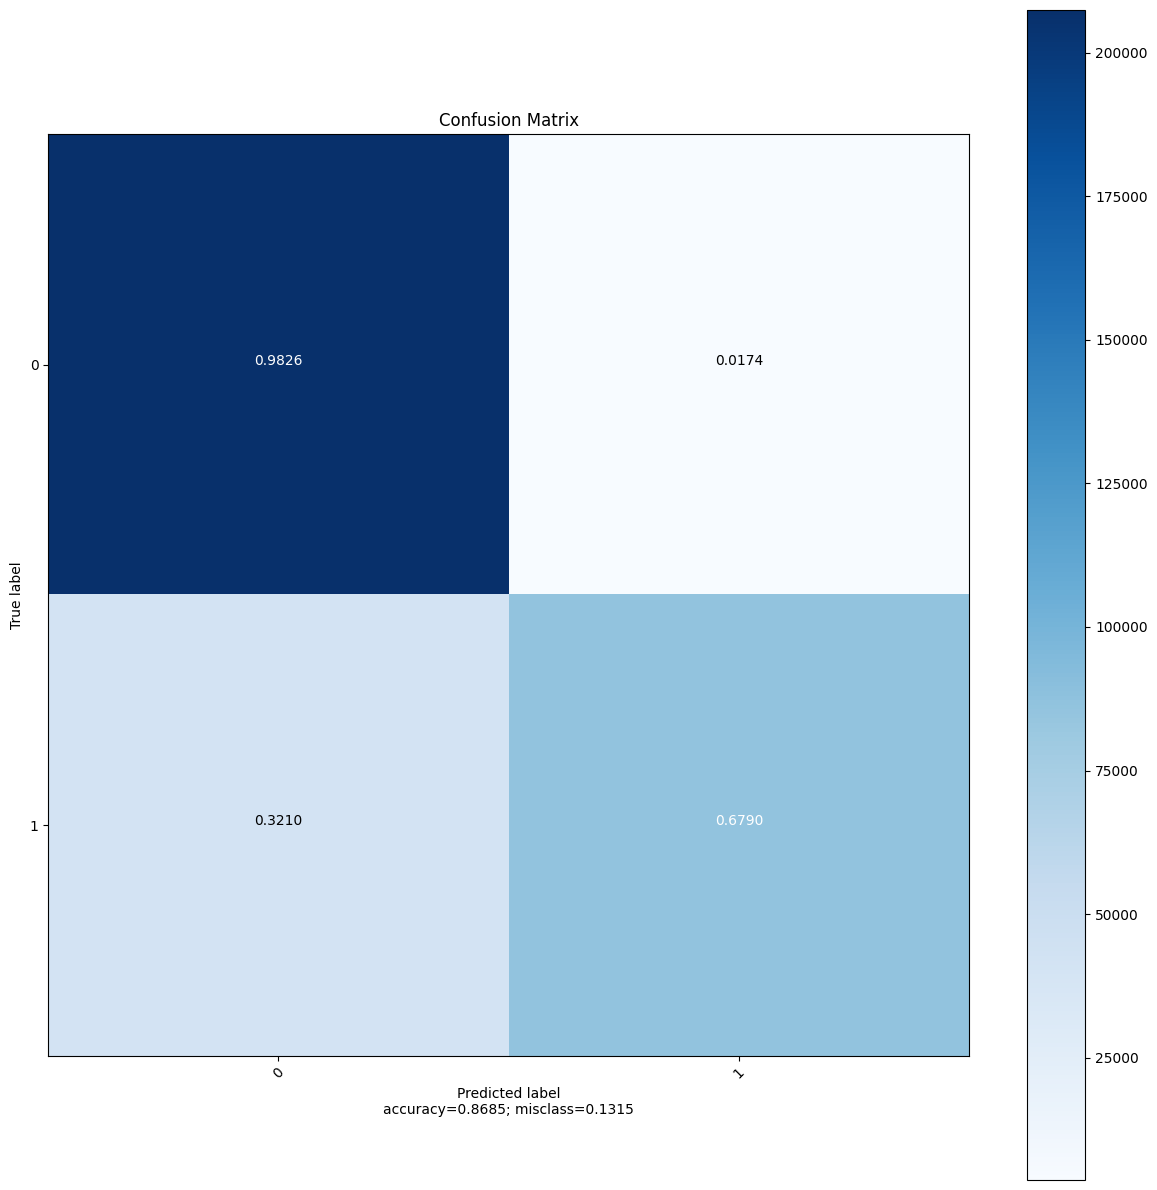

In [122]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(
    dataset=DATASET,
    cm=confusion_matrix(test_lbls, preds),
    normalize=True,
    target_names=np.unique(test_lbls),
    title="Confusion Matrix",
)

In [123]:
test_lbls = list(test_lbls)
preds = list(preds)

In [124]:
from sklearn.metrics import classification_report

target_names = np.unique(test_lbls)
target_names = target_names.astype(str)
cr = classification_report(test_lbls, preds, target_names=target_names, digits=4)
print(cr)

with open(f"{DATASET}_classification_report.txt", "w") as f:
    f.write(cr)

              precision    recall  f1-score   support

           0     0.8356    0.9826    0.9032    211144
           1     0.9593    0.6790    0.7952    127130

    accuracy                         0.8685    338274
   macro avg     0.8975    0.8308    0.8492    338274
weighted avg     0.8821    0.8685    0.8626    338274

